# Additional Supervised Learning Modeling

## Overview

After seeing that the model using Yelp was unable to predict affluency, the decision was made build a model using other types of data.  A number of socio-economic attributes were chosen as features.  The details of which are below.

|             |                                                                                                                      |
|-------------|----------------------------------------------------------------------------------------------------------------------|
| Education   | Percent of the population holding a high school degree or higher and bachelors degrees or higher                     |
| Crime       | The rates of property crimes and violent crimes per 100,000 people                                                   |
| Home Values | The Zillow index of median home values                                                                               |
| Population  | Population of city, population density (person per square miles and land area of the city (square miles of the city) |

A linear regression model was used with scaled and unscaled data along with a random forest model.

## Contents

[1. Adding Other Variables](#1.-Adding-Other-Variables)<br>
[2. Correlation of Income with new Variables](#2.-Correlation-of-Income-with-new-Variables)<br>
[3. Linear Regression Model](#3.-Linear-Regression-Model)<br>
[4. Scaled Data Model](#4.-Scaled-Data-Model)<br>
[5. Random Forest Model](#5.-Random-Forest-Model)<br>
[6. Conclusions](#6.-Conclusions)

### 1. Adding Other Variables

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import warnings

warnings.filterwarnings("ignore")

### Reading in and preparing data

In [2]:
education = pd.read_csv('../data/education_census.csv').drop(columns=['Id','Id2'])
income = pd.read_csv("../data/income.csv")
crime = pd.read_csv("../data/crime_data.csv")
homes = pd.read_csv("../data/zillow_home_index.csv")
population = pd.read_csv("../data/population_density.csv")

In [3]:
education[['city','state']] = education['Geography'].str.split(',', expand=True)
education['state'] = education['state'].str.strip()
education.drop(columns=['Geography'],inplace=True)

In [4]:

states = {"AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California","CO":"Colorado",
          "CT":"Connecticut","DE":"Delaware","FL":"Florida","GA":"Georgia","HI":"Hawaii","ID":"Idaho",
          "IL":"Illinois","IN":"Indiana","IA":"Iowa","KS":"Kansas","KY":"Kentucky","LA":"Louisiana",
          "ME":"Maine","MD":"Maryland","MA":"Massachusetts","MI":"Michigan","MN":"Minnesota","MS":"Mississippi",
          "MO":"Missouri","MT":"Montana","NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey",
          "NM":"New Mexico","NY":"New York","NC":"North Carolina","ND":"North Dakota","OH":"Ohio","OK":"Oklahoma",
          "OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota",
          "TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont","VA":"Virginia","WA":"Washington",
          "WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming"}

inverted_states = dict([[v,k] for k,v in states.items()])

abbrev_states = []
for i in list(education['state']):
    abbrev = inverted_states.get(i)
    abbrev_states.append(abbrev)

In [5]:
education['abbrev_state'] = abbrev_states

In [6]:
education = education[['city','state','abbrev_state','high_school_or_higher','bachelors_or_higher']]

In [7]:
education['high_school_or_higher'] = education['high_school_or_higher']/100
education['bachelors_or_higher'] = education['bachelors_or_higher']/100

In [8]:
crime.drop(columns=['city'],inplace=True)

In [9]:
homes.drop(columns=['city_state'],inplace=True)

In [10]:
population.drop(columns=['city_state','State'],inplace=True)

In [11]:
income = income[['abbrev_state','income']]

In [12]:
#Created a function to merge dataframes
def merge_new_variable(df,variable):
    new_df = pd.merge(df,variable,left_on='abbrev_state',right_on='abbrev_state')
    return new_df

In [13]:
#Merged dataframes
df = merge_new_variable(education,crime)
df = merge_new_variable(df,homes)
df = merge_new_variable(df,population)
df = merge_new_variable(df,income)

### 2. Correlation of Income with new Variables

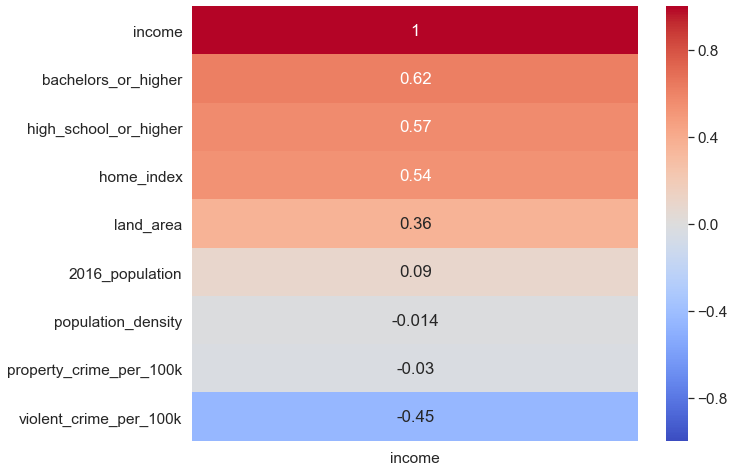

In [14]:
plt.figure(figsize=(10,8))
sns.set(font_scale=1.4)
sns.heatmap(df.corr()[['income']].sort_values('income', ascending=False),vmin=-1,cmap='coolwarm',annot=True);

### There was not a particularly strong correlation of the features with income

In [15]:
df.describe()

,high_school_or_higher,bachelors_or_higher,violent_crime_per_100k,property_crime_per_100k,home_index,population_density,2016_population,land_area,income
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000
mean,0.871100,0.346600,901.360000,4199.680000,262040.000000,4802.640000,7.642898e+05,208.290000,51774.700000
std,0.051837,0.097517,461.355313,1674.648138,119679.478404,4723.850292,1.333338e+06,277.068229,11330.305198
min,0.740000,0.142000,155.000000,1462.000000,91400.000000,175.000000,4.229200e+04,11.000000,28099.000000
25%,0.842500,0.280750,573.500000,3148.250000,191800.000000,1837.250000,1.828502e+05,54.750000,45291.500000
50%,0.884500,0.339000,816.000000,3910.500000,231100.000000,3133.500000,4.497860e+05,130.000000,51574.500000
75%,0.911250,0.399250,1111.250000,4790.750000,291375.000000,6096.500000,6.730868e+05,243.750000,56714.000000
max,0.944000,0.617000,2047.000000,8598.000000,674600.000000,28211.000000,8.537673e+06,1705.000000,85634.000000


### 3. Linear Regression Model

In [16]:
#Instantiate model
lr = LinearRegression()

In [17]:
#Create features and assign X and y
features = ['high_school_or_higher','bachelors_or_higher','violent_crime_per_100k', 'property_crime_per_100k',
            'home_index','2016_population','population_density','land_area']
X = df[features]
y = df['income']

In [18]:
# Train/test split the data.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25, random_state=42)

In [19]:
#Fit the model
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
# Score on training set.
print(f'Training Score: {round(r2_score(y_train,lr.predict(X_train)),4)}.')

Training Score: 0.8609.


In [21]:
# Score on testing set.
print(f'Test Score: {round(r2_score(y_test,lr.predict(X_test)),4)}.')

Test Score: 0.3832.


In [22]:
lr.coef_

array([ 1.13190592e+05,  2.02513931e+04, -3.65627646e+00, -1.13471396e-01,
        3.95682891e-02, -1.20342184e-03,  3.52437314e-01,  1.71125321e+01])

In [23]:
lr.intercept_

-64548.869949551

In [24]:
preds = lr.predict(X_test)

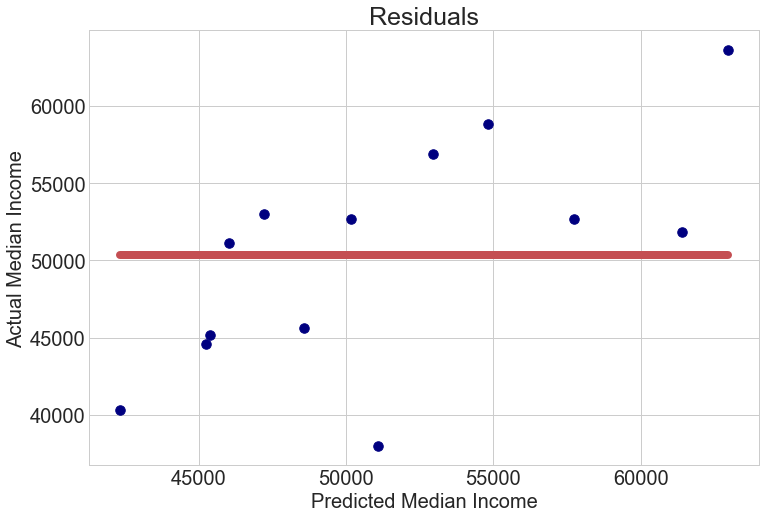

In [38]:
#Plot residuals
plt.figure(figsize = (12,8))
plt.style.use('seaborn-whitegrid')
plt.scatter(preds,y_test,c='navy',s=90);
plt.plot((np.min(preds), np.max(preds)),
        (np.mean(y_test), np.mean(y_test)),
       color='r',linewidth=8);

plt.title("Residuals",fontsize=25)
plt.xlabel("Predicted Median Income",fontsize=20)
plt.ylabel("Actual Median Income",fontsize=20);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## 4. Scaled Data Model

In [39]:
#Scale the data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

In [40]:
#Fit the model
lr.fit(X_train_ss,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
lr.coef_

array([ 5965.23990285,  2111.68660768, -1711.76868676,  -182.02333502,
        4808.25508993,  -873.32370511,  1030.07149907,  5261.88628321])

In [42]:
lr.intercept_

52278.40540540539

In [43]:
print(f'Training Score: {round(r2_score(y_train,lr.predict(X_train_ss)),4)}.')

Training Score: 0.8609.


In [44]:
print(f'Test Score: {round(r2_score(y_test,lr.predict(X_test_ss)),4)}.')

Test Score: 0.0319.


In [45]:
preds_ss = lr.predict(X_test_ss)

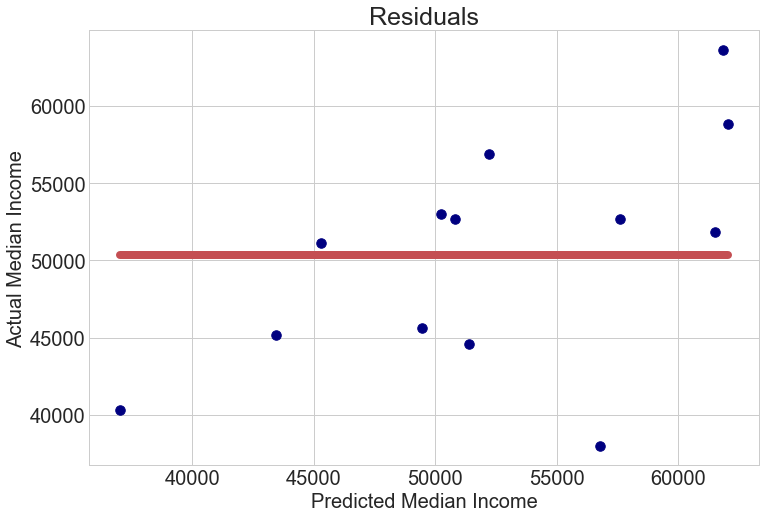

In [46]:
#Plot residuals
plt.figure(figsize = (12,8))
plt.style.use('seaborn-whitegrid')
plt.scatter(preds_ss,y_test,c='navy',s=90);
plt.plot((np.min(preds_ss), np.max(preds_ss)),
        (np.mean(y_test), np.mean(y_test)),
       color='r',linewidth=8);

plt.title("Residuals",fontsize=25)
plt.xlabel("Predicted Median Income",fontsize=20)
plt.ylabel("Actual Median Income",fontsize=20);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## 5. Random Forest Model

In [47]:
rf = RandomForestRegressor()

In [48]:
et = ExtraTreesRegressor()

In [49]:
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.6264892262886343

In [50]:
cross_val_score(et, X_train, y_train, cv=5).mean()

0.6494991947270912

In [51]:
rf = RandomForestRegressor()
random_state=42
rf_params = {
    'n_estimators':[50, 100, 150,200],
    'max_depth': [None, 2,3,4,5],
    
}

gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train, y_train)
print (gs.best_score_)
gs.best_params_

0.6527312254738696


{'max_depth': None, 'n_estimators': 50}

In [52]:
gs.score(X_train, y_train)

0.9450790783891766

In [53]:
gs.score(X_test, y_test)

-1.0817012406871105

In [54]:
preds_gs = gs.predict(X_test)

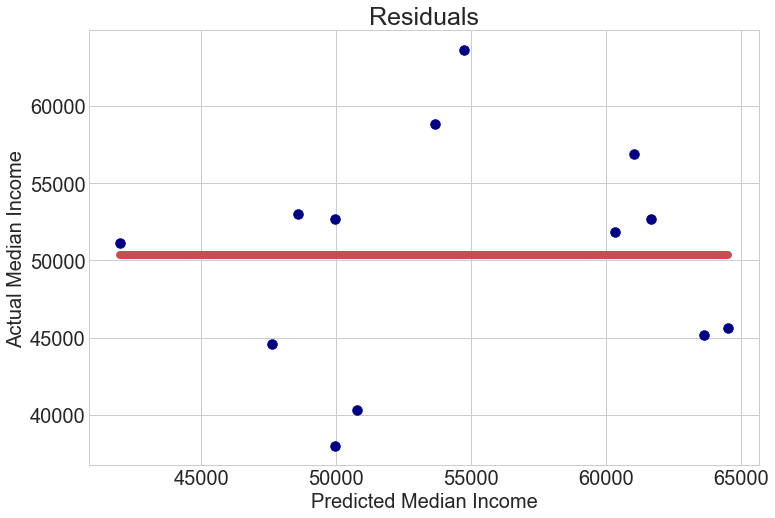

In [55]:
#Plot residuals
plt.figure(figsize = (12,8))
plt.style.use('seaborn-whitegrid')
plt.scatter(preds_gs,y_test,c='navy',s=90);
plt.plot((np.min(preds_gs), np.max(preds_gs)),
        (np.mean(y_test), np.mean(y_test)),
       color='r',linewidth=8);



plt.title("Residuals",fontsize=25)
plt.xlabel("Predicted Median Income",fontsize=20)
plt.ylabel("Actual Median Income",fontsize=20);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## 6. Conclusions

All of the models were overfit and not very predictive.  This is attributed to the small number of observations in the dataset.  Future work should be done with additional observations and a wider set of features.